In this file the filtering methods will be explored **but each OMICS type data will be processed separately**

Everything is done on the training set which includes 58 samples (out of 96)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from feature_selection import *
from helper import *
import seaborn as sns
import random
import math
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"
xls = pd.ExcelFile(path)
metabolomics = pd.read_excel(xls, "Metabolomics")
lipidomics = pd.read_excel(xls, "Lipidomics")
proteomics = pd.read_excel(xls, "Proteomics")

print(type(metabolomics), metabolomics.shape)
print(type(lipidomics), lipidomics.shape)
print(type(proteomics), proteomics.shape)

<class 'pandas.core.frame.DataFrame'> (96, 216)
<class 'pandas.core.frame.DataFrame'> (96, 581)
<class 'pandas.core.frame.DataFrame'> (96, 323)


In [3]:
# Retrieve the training sets
metabolomics_train, _ = get_train_test_split_dataset(metabolomics)
lipidomics_train, _ = get_train_test_split_dataset(lipidomics)
proteomics_train, _ = get_train_test_split_dataset(proteomics)

Training set shape:  (58, 216)
Testing set shape:  (38, 216)
Training set shape:  (58, 581)
Testing set shape:  (38, 581)
Training set shape:  (58, 323)
Testing set shape:  (38, 323)


In [4]:

def plot_initial_distribution(metabolomics_, lipidomics_, proteomics_):
    """
    Plot how much each omics type contributes to the dataset
    """
    
    print("Total number of samples: ", len(metabolomics_.index))
    
    count = [
        len(metabolomics_.columns) - 3, 
        len(lipidomics_.columns) - 3, 
        len(proteomics_.columns) - 3]
    names = ["Metabolomics", "Lipidomics", "Proteomics"]
    data = pd.DataFrame({"Dataset Size": count, "Omics Type": names})
    
    plt.figure(figsize=(5.0, 2.0))
    ax = sns.barplot(
        data, 
        x="Dataset Size", y="Omics Type", orient="h",
        palette="viridis"
    )
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title("Contribution of each Omics type to the dataset")

Total number of samples:  58


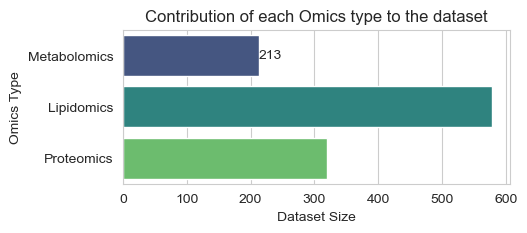

In [5]:
plot_initial_distribution(metabolomics_train, lipidomics_train, proteomics_train)

In [6]:
def omics_filtering(dataset_, title, k=None):
    if k is None:
        k = round(len(dataset_.columns) * 0.75)
    
    print("Number of features before filtering: ", len(dataset_.columns))
    Y_ = np.ravel(dataset_[['ThreeClass']])
    X_ = dataset_.copy()
    
    drop_columns = ['ThreeClass', 'RID', 'TwoClass']
    for column in drop_columns:
        if column in dataset_.columns:
            X_ = X_.drop(column, axis=1)
    
    ANOVA_ = ANOVA_correlation_filtering(k, X_, Y_)
    MIFS_ = mutual_information_filtering(k, X_, Y_)
    RFE_ = recursive_feature_elimination(k, X_, Y_)
    variance_ = variance_filtering(X_)
    
    # Find intersection of features that are selected by all methods
    intersection = (set(ANOVA_).
                    intersection(set(MIFS_)).
                    intersection(set(RFE_)).
                    intersection(set(variance_)))
    relative_frequency = round(len(intersection) * 100 / len(X_.columns), 2)
    print("\nIntersection of all methods: ", len(intersection), " (", relative_frequency, "%)")
    
    union = (set(ANOVA_).
             union(set(MIFS_)).
             union(set(RFE_)).
             union(set(variance_)))
    relative_frequency = round(len(union) * 100 / len(X_.columns), 2)
    print("Union of all methods: ", len(union), " (", relative_frequency, "%)")
    
    venn_diagram(
        [set(ANOVA_), set(MIFS_), set(RFE_)],
        ("ANOVA correlation", "Mutual information", "RFE"),
        title
    )
    venn_diagram(
        [set(ANOVA_), set(MIFS_), set(variance_)],
        ("ANOVA correlation", "Mutual information", "Variance"),
        title
    )

Number of features before filtering:  323

Intersection of all methods:  150  ( 46.88 %)
Union of all methods:  320  ( 100.0 %)


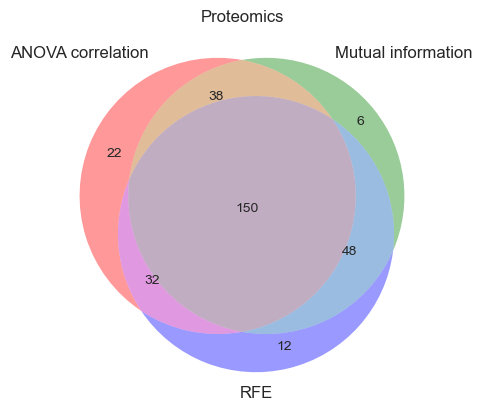

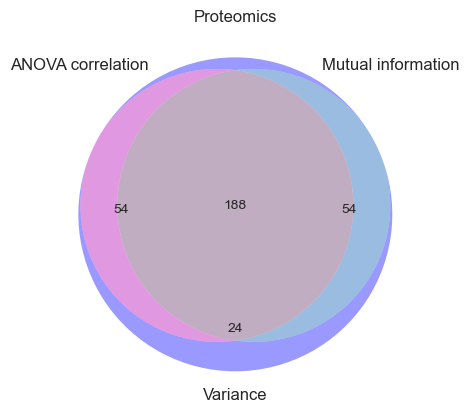

In [7]:
omics_filtering(proteomics_train, "Proteomics")

Number of features before filtering:  581

Intersection of all methods:  264  ( 45.67 %)
Union of all methods:  578  ( 100.0 %)


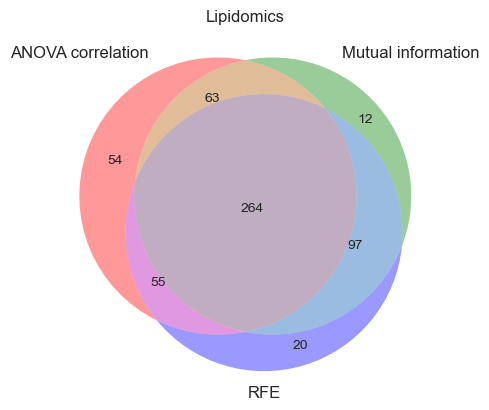

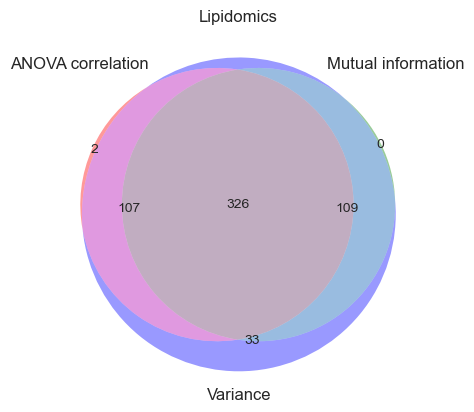

In [8]:
omics_filtering(lipidomics_train, "Lipidomics")

Number of features before filtering:  216

Intersection of all methods:  60  ( 28.17 %)
Union of all methods:  209  ( 98.12 %)


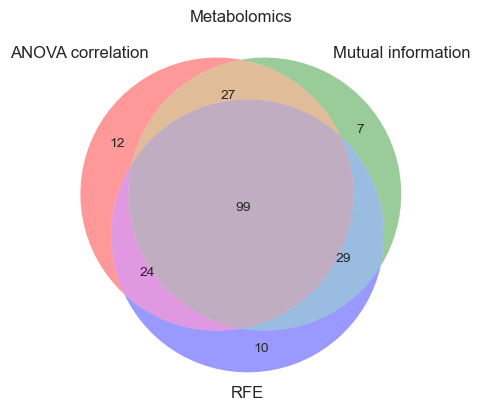

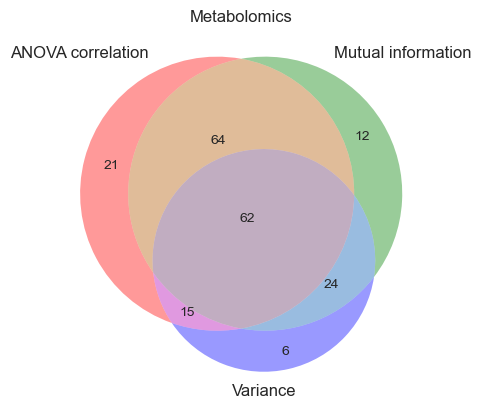

In [9]:
omics_filtering(metabolomics_train, "Metabolomics")

### Investigating discrepancy between ANOVA and variance in metabolomics data

**Conclusions:**
- Normalization needs to be used for the metabolomics data
- Variance filtering has to be very lenient (now 0.01, max 0.02) not to lose too many features

In most of the papers I have read, the normalization is done separately for each omics type and then the data is combined.

**TODO**
Ask about the normalization methods
Implement RelieF feature selection method as it is the most popular and mentioned in every paper.


In [10]:
def commit_test(dataset_, labels_):
    """
    Take random n features from the difference and intersection sets of ANOVA and variance
    Create a box plot for each feature to see the distribution of the data
    """
    
    n = round(len(dataset_.columns) * 0.75)
    ANOVA_ = ANOVA_correlation_filtering(n, dataset_, labels_)
    variance_ = variance_filtering(dataset_)
    venn_diagram(
        [set(ANOVA_), set(variance_)],
        ("ANOVA correlation", "Variance"),
        "Metabolomics")

    # Find the difference between ANOVA and variance
    difference_ = set(ANOVA_).difference(set(variance_))
    intersection_ = set(ANOVA_).intersection(set(variance_))
    print("Difference Set: ", len(difference_))
    print("Intersection Set: ", len(intersection_))
    
    # Take random k features from the difference and intersection and plot them
    k = 2
    if not list(difference_):
        print("Difference set is empty")
        return
    
    difference_features = random.sample(list(difference_), k)
    intersection_features = random.sample(list(intersection_), k)
    dataset_["ThreeClass"] = labels_
    
    # Plot the features
    fig, axes = plt.subplots(2, k, figsize=(6, 5))
    y_lim_max = max(
        dataset_[difference_features].max().max(), 
        dataset_[intersection_features].max().max()
    ) + 1
    y_lim_min = min(
        dataset_[difference_features].min().min(), 
        dataset_[intersection_features].min().min()
    ) - 1
    
    colors_ = sns.color_palette("magma", 3)
    for i, feature in enumerate(difference_features):
        sns.boxplot(
            x="ThreeClass", y=feature, data=dataset_, ax=axes[0, i], palette=colors_, linewidth=.65
        )
        axes[0, i].set_ylim(y_lim_min, y_lim_max)
    for i, feature in enumerate(intersection_features):
        sns.boxplot(
            x="ThreeClass", y=feature, data=dataset_, ax=axes[1, i], palette=colors_, linewidth=.65
        )
        axes[1, i].set_ylim(y_lim_min, y_lim_max)
    # Add title to the first row
    axes[0, 0].set_title("Difference Set Between ANOVA and Variance", size=10)
    axes[1, 0].set_title("Intersection Set Between ANOVA and Variance", size=10)
    plt.tight_layout()
    plt.show()

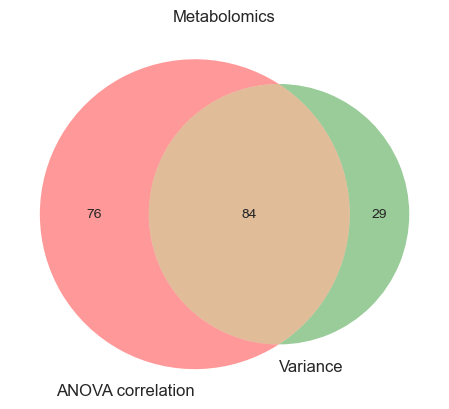

Difference Set:  76
Intersection Set:  84


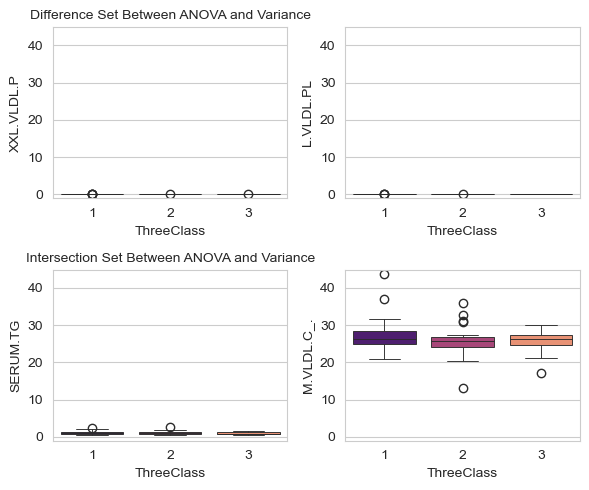

In [11]:
metabolomics_test = metabolomics.drop(['ThreeClass', 'RID', 'TwoClass'], axis=1)
labels = np.ravel(metabolomics[['ThreeClass']])
commit_test(metabolomics_test, labels)

### Normalization of Metabolomics Data

Pareto Scaling seems to be the most popular method in metabolomics



In [12]:
def range_scaling(dataset_):
    """
    https://www.uab.edu/proteomics/metabolomics/workshop/2014/statistical%20analysis.pdf
    Uses min and max values of each feature to scale the data
    Very sensitive to outliers!
    :param dataset_: original non-normalized dataset
    :return: normalized dataset
    """
    for feature in dataset_.columns:
        min_value = dataset_[feature].min()
        max_value = dataset_[feature].max()
        new_column = (dataset_[feature] - min_value) / (max_value - min_value)
        dataset_[feature] = new_column
    return dataset_

def pareto_scaling(dataset_):
    """
    https://www.rdocumentation.org/packages/MetabolAnalyze/versions/1.3.1/topics/scaling
    https://uab.edu/proteomics/metabolomics/workshop/2014/statistical%20analysis.pdf
    Pareto scaling is often used in metabolomics. 
    It scales data by dividing each variable by the square root of the standard deviation,
    so that each variable has variance equal to 1.
    :param dataset_: original non-normalized dataset
    :return: normalized dataset
    """
    for feature in dataset_.columns:
        std = dataset_[feature].std()
        scaling_factor = math.sqrt(std)
        dataset_[feature] = dataset_[feature] / scaling_factor
    return dataset_

In [13]:
def plot_normalization(original_dataset, normalized_dataset, title=None, num_boxes=7): 
    # Create box plots to see the distribution of normalized data
    random_indices = random.sample(range(len(normalized_dataset.columns)), num_boxes)
    original_dataset = original_dataset.iloc[:, random_indices]
    normalized_dataset = normalized_dataset.iloc[:, random_indices]
    
    fig, axes = plt.subplots(2, figsize=(num_boxes, 5))
    colors_ = sns.color_palette("cubehelix", num_boxes)
    sns.boxplot(
        data=original_dataset, ax=axes[0], palette=colors_, linewidth=.45
    )
    sns.boxplot(
        data=normalized_dataset, ax=axes[1], palette=colors_, linewidth=.45
    )
    axes[0].title.set_text("Original Data")
    axes[1].title.set_text("Normalized Data")
    if title is not None:
        plt.suptitle(title)
    
    plt.tight_layout()
    plt.show()

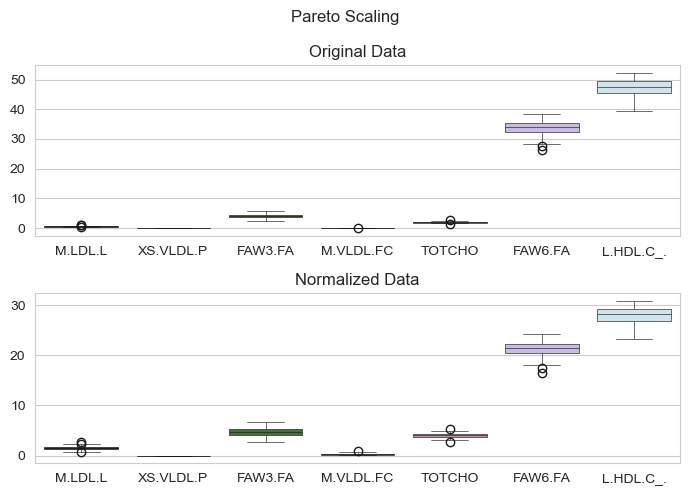

In [14]:
plot_normalization(
    original_dataset=metabolomics_train[metabolomics_train.columns[3:]],
    normalized_dataset=pareto_scaling(metabolomics_train[metabolomics_train.columns[3:]]),
    title="Pareto Scaling",
)

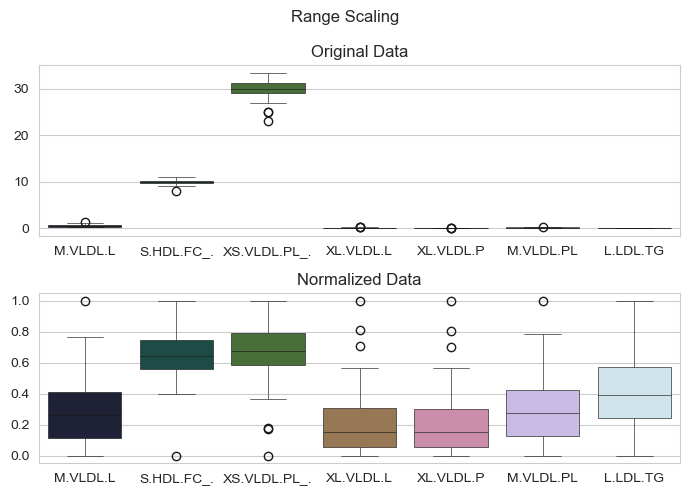

In [15]:
plot_normalization(
    metabolomics_train[metabolomics_train.columns[3:]],
    range_scaling(metabolomics_train[metabolomics_train.columns[3:]]),
    "Range Scaling"
)

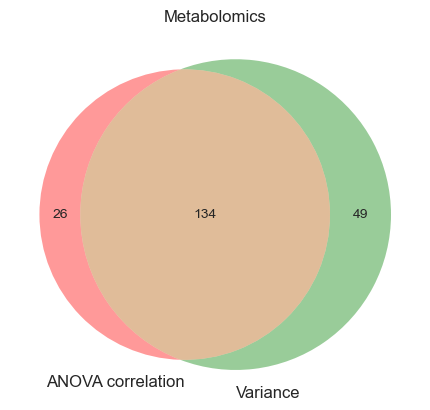

Difference Set:  26
Intersection Set:  134


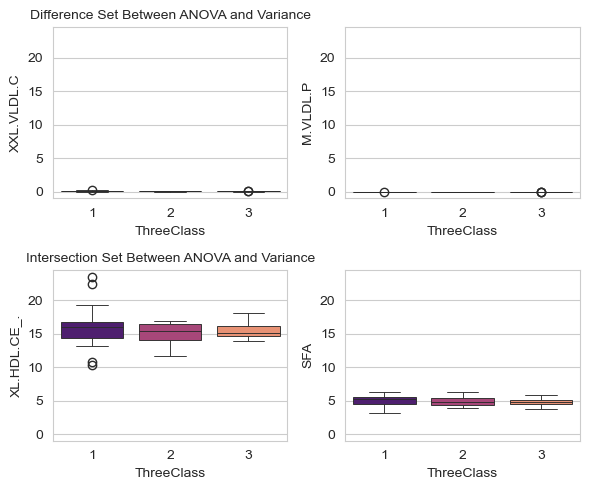

In [16]:
commit_test(
    pareto_scaling(metabolomics_train[metabolomics_train.columns[3:]]),       
    metabolomics_train["ThreeClass"]
)

Number of features before filtering:  216

Intersection of all methods:  89  ( 41.78 %)
Union of all methods:  212  ( 99.53 %)


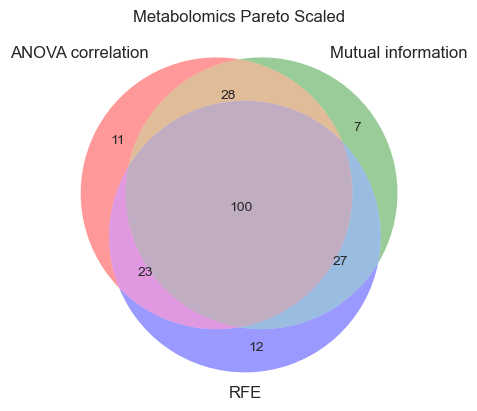

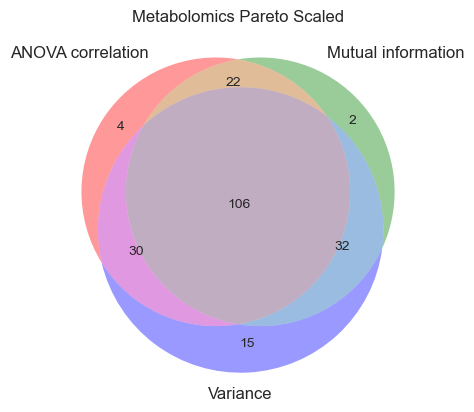

In [17]:
pareto_scaled_metabolomics = pareto_scaling(metabolomics_train[metabolomics_train.columns[3:]])
# Add the labels back to the dataset
pareto_scaled_metabolomics["ThreeClass"] = metabolomics_train["ThreeClass"]
pareto_scaled_metabolomics["RID"] = metabolomics_train["RID"]
pareto_scaled_metabolomics["TwoClass"] = metabolomics_train["TwoClass"]
omics_filtering(
    pareto_scaled_metabolomics, 
    "Metabolomics Pareto Scaled")

### Investigate whether Lipidomics and Proteomics data needs normalization / scaling as well

From the histograms it is clear that Pareto scaling was very effective for the metabolomics data.
Proteomics seems to have a wide range of standard deviations, so it might need scaling as well.
On the other hand, lipidomics data seems to be already fine.

In [18]:
def plot_feature_variances(dataset_, title, colors, num_bins='auto'):
    """
    For each feature compute the variance and plot a histogram of all the values
    This is needed to assess whether the data needs normalization / scaling
    
    If the histogram shows a wide range of standard deviations, 
    this indicates that features vary greatly in their scale.
    """
    columns_to_drop = ['ThreeClass', 'RID', 'TwoClass']
    if all(column in dataset_.columns for column in columns_to_drop):
        dataset_ = dataset_.drop(['RID', 'ThreeClass', 'TwoClass'], axis=1)
    feature_variances = dataset_.var()
    
    # Create a histogram to see the distribution of variances
    plt.figure(figsize=(6, 3))
    plot = sns.histplot(feature_variances, kde=False, color=colors, bins=num_bins)
    print("Number of bins: ", len(plot.patches))
    plt.title("Histogram of " + title + " Feature Variances")
    plt.xlabel("Feature Variance")
    plt.ylabel("Frequency")
    plt.show()

Number of bins:  96


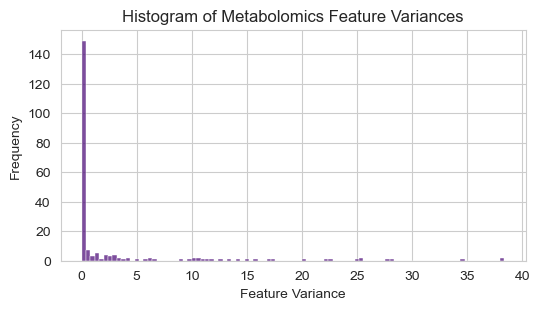

Number of bins:  21


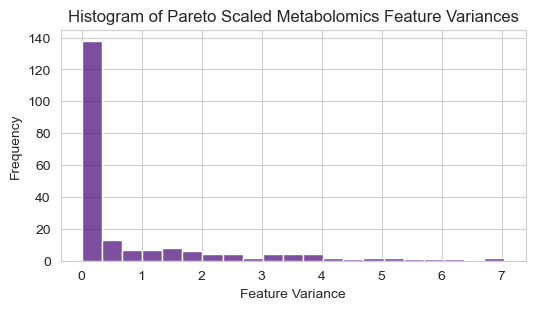

In [19]:
colors_ = sns.color_palette("magma", 3)
plot_feature_variances(
    metabolomics, "Metabolomics", colors_[0])
plot_feature_variances(
    pareto_scaled_metabolomics, "Pareto Scaled Metabolomics", colors_[0])

Number of bins:  36


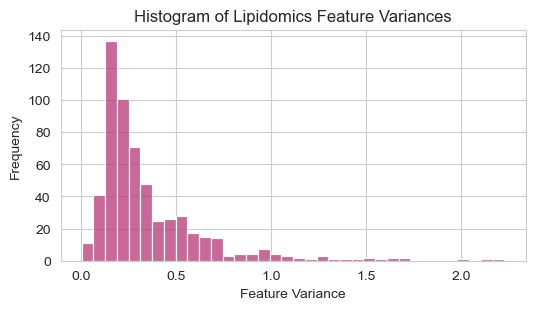

In [20]:
# Valentin already log normalized the lipidomics data
plot_feature_variances(
    lipidomics_train, "Lipidomics", colors_[1])

Number of bins:  150


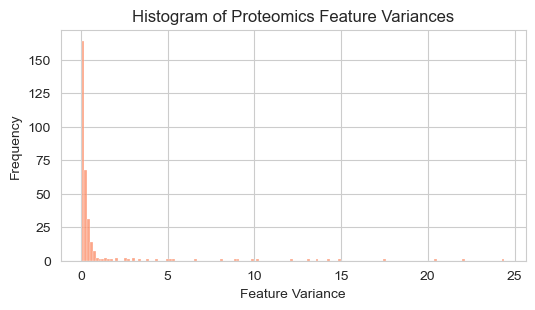

In [21]:
plot_feature_variances(
    proteomics_train, "Proteomics", colors_[2], num_bins=150)

### Normalization of Proteomics Data


In [22]:
import qnorm
def quantile_normalization(dataset_):
    """
    Ensures that the distribution of feature intensities is the same across all samples
    Doesn't seem to be very effective here
    """
    return qnorm.quantile_normalize(dataset_.copy(), axis=1)

def log_transformation(dataset_):
    """
    Log transformation is often used in proteomics
    It stabilizes the variance and reduces the skewness of the data
    """
    return np.log2(dataset_ + 1)

def z_score_normalization(dataset_):
    """
    Standardizes the features based on their mean and standard deviation
    """
    return (dataset_ - dataset_.mean()) / dataset_.std()

Number of bins:  150


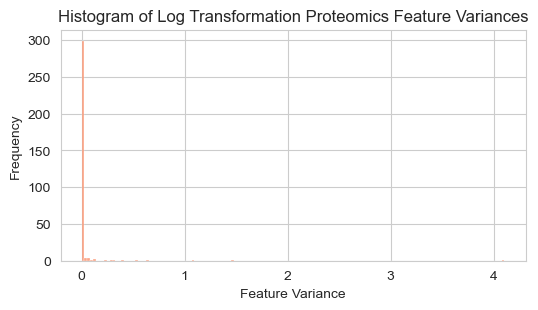

In [23]:
plot_feature_variances(
    log_transformation(proteomics[proteomics.columns[3:]]), 
    "Log Transformation Proteomics", colors_[2], num_bins=150)

Number of bins:  150


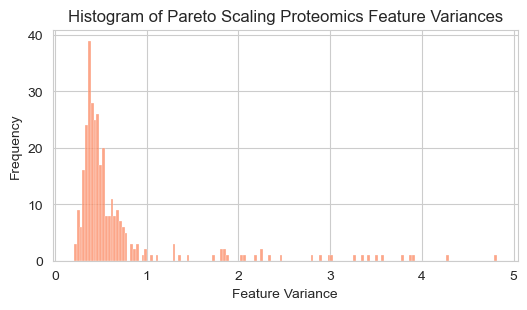

In [24]:
plot_feature_variances(
    pareto_scaling(proteomics[proteomics.columns[3:]]), 
    "Pareto Scaling Proteomics", colors_[2], num_bins=150)

# Saving the datasets

In [25]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xlsx"

pareto_proteomics = pareto_scaling(proteomics[proteomics.columns[3:]])
pareto_proteomics["ThreeClass"] = proteomics["ThreeClass"]
pareto_proteomics["RID"] = proteomics["RID"]
pareto_proteomics["TwoClass"] = proteomics["TwoClass"]
# Move RID, ThreeClass and TwoClass to the first columns
pareto_proteomics = pareto_proteomics[
    ['RID', 'ThreeClass', 'TwoClass'] + [col for col in pareto_proteomics.columns if col not in ['RID', 'ThreeClass', 'TwoClass']]
]

pareto_metabolomics = pareto_scaling(metabolomics[metabolomics.columns[3:]])
pareto_metabolomics["ThreeClass"] = metabolomics["ThreeClass"]
pareto_metabolomics["RID"] = metabolomics["RID"]
pareto_metabolomics["TwoClass"] = metabolomics["TwoClass"]
# Move RID, ThreeClass and TwoClass to the first columns
pareto_metabolomics = pareto_metabolomics[
    ['RID', 'ThreeClass', 'TwoClass'] + [col for col in pareto_metabolomics.columns if col not in ['RID', 'ThreeClass', 'TwoClass']]
]


# Save the datasets in different sheets
with pd.ExcelWriter(path, engine='openpyxl') as writer:
    metabolomics.to_excel(writer, sheet_name='Metabolomics', index=False)
    lipidomics.to_excel(writer, sheet_name='Lipidomics', index=False)
    proteomics.to_excel(writer, sheet_name='Proteomics', index=False)
    pareto_metabolomics.to_excel(writer, sheet_name='Pareto Metabolomics', index=False)
    pareto_proteomics.to_excel(writer, sheet_name='Pareto Proteomics', index=False)    